# Representing Agents and Environments

**Reference**: *Artificial Intelligence: Foundations of Computational Agents, 3e*

An **environment** takes in actions of the agents, updates it internal state and returns the next percept, using the method do.

An **agent** takes the precept, updates its internal state, and output it next action.

An agent implements the method *select_action* that takes percept
and returns its next action.

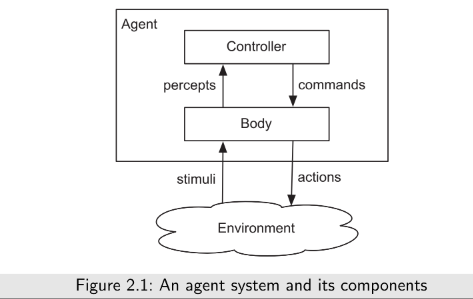

An **agent** is made up of a body and a **controller**.

The **controller** receives percepts from the body and sends commands to the body.

A **body** includes sensors that convert stimuli into percepts and actuators
that convert commands into actions.

Stimuli include light, sound, words typed on a keyboard, mouse movements, and physical bumps. The stimuli can also include information obtainedfrom a web page or from a database.

## Utility Functions

A simple way to trace the intermediate steps of algorithms.

In [ ]:
class Displayable(object):
    """Class that uses 'display'.
    The amount of detail is controlled by max_display_level
    """
    max_display_level = 1   # can be overridden in subclasses

    def display(self,level,*args,**nargs):
        """print the arguments if level is less than or equal to the
        current max_display_level.
        level is an integer.
        the other arguments are whatever arguments print can take.
        """
        if level <= self.max_display_level:
            print(*args, **nargs)  ##if error you are using Python2 not Python3

def visualize(func):
    """A decorator for algorithms that do interactive visualization.
    Ignored here.
    """
    return func

## Agents

In [ ]:
class Agent(object):
    def __init__(self,env):
        """set up the agent"""
        self.env=env

    def go(self,n):
        """acts for n time steps"""
        raise NotImplementedError("go")   # abstract method

## Environment

In [ ]:
class Environment(Displayable):
    def initial_percepts(self):
        """returns the initial percepts for the agent"""
        raise NotImplementedError("initial_percepts")   # abstract method

    def do(self,action):
        """does the action in the environment
        returns the next percept """
        raise NotImplementedError("do")   # abstract method

## Paper buying agent and environment

Consider a household trading agent that monitors the price of
some commodity (e.g., it checks online for special deals and for price increases for toilet paper) and how much the household has in stock. It must decide whether to buy more and how much to buy. The percepts are the price and the amount in stock. The command is the number of units the agent decides to buy (which is zero if the agent does not buy any). A percept trace specifies for each time point (e.g., each day) the price at that time and the amount in stock at that time. Percept traces are given in Figure 1.

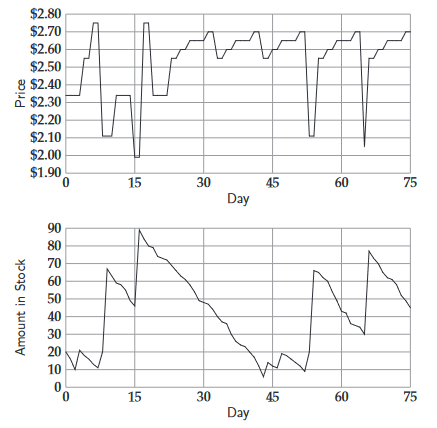

A command trace specifies how much the agent decides to buy at each time point. An example command trace is given in Figure 2.
The action of actually buying depends on the command but may be dif-
ferent. For example, the agent could issue a command to buy 12 rolls of toilet paper at a particular price. This does not mean that the agent actually buys 12 rolls because there could be communication problems, the store could have run out of toilet paper, or the price could change between deciding to buy and actually buying.


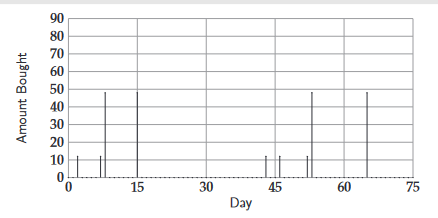

The environment state is given in terms of the time and the amount of paper in stock. It also remembers the in-stock history and the price history. The percept consistes of the price and the amount of paper in stock. The action of the agent is the number to buy.

Here we assume that the prices are obtained from the prices list (which cycles) plus a random integer in range [0, max price addon) plus a linear
linear ”inflation”. The agent cannot access the price model; it just observes the prices and the amount in stock

### Environment

In [ ]:
import random

class TP_env(Environment):
    prices = [234, 234, 234, 234, 255, 255, 275, 275, 211, 211, 211,
    234, 234, 234, 234, 199, 199, 275, 275, 234, 234, 234, 234, 255,
    255, 260, 260, 265, 265, 265, 265, 270, 270, 255, 255, 260, 260,
    265, 265, 150, 150, 265, 265, 270, 270, 255, 255, 260, 260, 265,
    265, 265, 265, 270, 270, 211, 211, 255, 255, 260, 260, 265, 265,
    260, 265, 270, 270, 205, 255, 255, 260, 260, 265, 265, 265, 265,
    270, 270]
    max_price_addon = 20  # maximum of random value added to get price

    def __init__(self):
        """paper buying agent"""
        self.time=0
        self.stock=20
        self.stock_history = []  # memory of the stock history
        self.price_history = []  # memory of the price history

    def initial_percepts(self):
        """return initial percepts"""
        self.stock_history.append(self.stock)
        price = self.prices[0] + random.randrange(self.max_price_addon)
        self.price_history.append(price)
        return {'price': price,
                'instock': self.stock}

    def do(self, action):
        """does action (buy) and returns percepts (price and instock)"""
        used = pick_from_dist({6:0.1, 5:0.1, 4:0.2, 3:0.3, 2:0.2, 1:0.1})
        bought = action['buy']
        self.stock = self.stock+bought-used
        self.stock_history.append(self.stock)
        self.time += 1
        price = (self.prices[self.time%len(self.prices)] # repeating pattern
                 +random.randrange(self.max_price_addon) # plus randomness
                 +self.time//2)                          # plus inflation
        self.price_history.append(price)
        return {'price': price,
                'instock': self.stock}

In [ ]:
def pick_from_dist(item_prob_dist):
    """ returns a value from a distribution.
    item_prob_dist is an item:probability dictionary, where the probabilities sum to 1.
    returns an item chosen in proportion to its probability
    """
    ranreal = random.random()
    for (it,prob) in item_prob_dist.items():
        if ranreal < prob:
            return it
        else:
            ranreal -= prob
    raise RuntimeError(str(item_prob_dist)+" is not a probability distribution")

### Agent

In [ ]:
class TP_agent(Agent):
    def __init__(self, env):
        self.env = env
        self.spent = 0
        percepts = env.initial_percepts()
        self.ave = self.last_price = percepts['price']
        self.instock = percepts['instock']

    def go(self, n):
        """go for n time steps
        """
        for i in range(n):
            if self.last_price < 0.9*self.ave and self.instock < 60:
                tobuy = 48
            elif self.instock < 12:
                tobuy = 12
            else:
                tobuy = 0
            self.spent += tobuy*self.last_price
            percepts = env.do({'buy': tobuy})
            self.last_price = percepts['price']
            self.ave = self.ave+(self.last_price-self.ave)*0.05
            self.instock = percepts['instock']

In [ ]:
env = TP_env()
ag = TP_agent(env)
ag.go(90)
ag.spent/env.time   ## average spent per time period

980.0

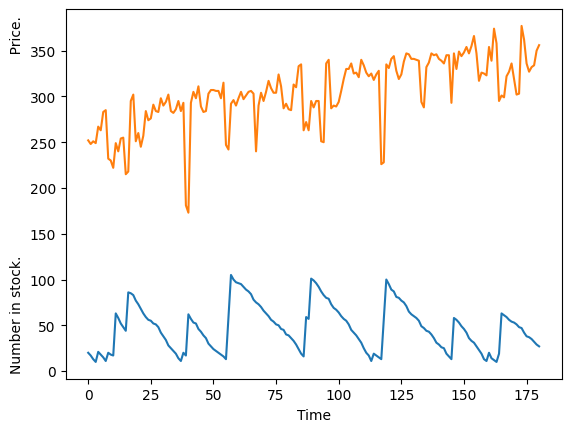

In [ ]:
import matplotlib.pyplot as plt

class Plot_prices(object):
    """Set up the plot for history of price and number in stock"""
    def __init__(self, ag,env):
        self.ag = ag
        self.env = env
        plt.ion()
        plt.xlabel("Time")
        plt.ylabel("Number in stock.Price.")

    def plot_run(self):
        """plot history of price and instock"""
        num = len(env.stock_history)
        plt.plot(range(num),env.stock_history,label="In stock")
        plt.plot(range(num),env.price_history,label="Price")
        #plt.legend(loc="upper left")
        plt.draw()

pl = Plot_prices(ag,env)
ag.go(90);
pl.plot_run()

## Exercise

Design a better controller for a paper-buying agent.

- Justify a performance measure that is a fair comparison. Note that minimizing the total amount of money spent may be unfair to agents who have built
up a stockpile, and favors agents that end up with no paper.

- Give a controller that can work for many different price histories. An agent can use other local state variables, but does not have access to the environment model.

- Is it worthwhile trying to infer the amount of paper that the home uses?
